In [2]:
import shogi
import cshogi
import re
import glob
import time
import datetime
from tools.PatternFacter import Pattern
from cshogi.usi import Engine
from cshogi.cli import usi_info_to_score, usi_info_to_csa_comment, re_usi_info
import configparser
import sys
import shogi.KIF

config = configparser.ConfigParser()
config.read("config.ini", encoding="utf-8")

#エンジン読み込み、設定変更はここ
engine = Engine(config.get("DEFAULT", "Enginepath") , debug=False)
engine.setoption("NodesLimit", config.get("DEFAULT", "Nodeslimit"))

#以下は触らない
engine.setoption("MultiPV", "2")
engine.isready()

In [3]:
import shogi.KIF
kif = shogi.KIF.Parser.parse_file('use_kif\kiou\kiou201502110101.kif')[0]
Pattern(' 104 投了         ( 0:00/03:26:00)').fact_kif()

True

## 必要な情報
- 対局者
    - 先手
    - 後手
- 持ち時間
- 指し手(sfen)
- 残り時間:標準化
- 評価値；標準化


In [28]:
class Formats:
    """Make Sfen and Time Kif
    ファイル情報を整理して別のファイルにコンバートするためのモジュール

    """
    def __init__(self, path):
        """initialize
        
        Parameters
        ----------
        path:str
            棋譜ファイルのパス
        kif:list -> str
            棋譜ファイルの中身(1行ずつリストで保持）
        fptime: datetime
            先手の残り時間
        lptime: datetime
            後手の残り時間
            
        """
        self.path = path
        with open(path, mode="r", encoding='shift-jis') as f:
            self.kif = f.readlines()
        self.fptime = self.time(mode="n")
        self.lptime = self.time(mode="n")
    
    def readline(self):
        """
        棋譜ファイルのリスト書き出し
        
        Returns
        -------
        kif:list
            棋譜ファイルを1行ごとにリストにしたもの
        """
        return self.kif
    
    def time(self, mode='u'):
        """
        対局開始時の持ち時間を返す関数
        
        Parameters
        ----------
        mode: str
            'u': unixタイムを返す
            'n': 通常の時間を返す
        """
        tmp =  int(self.kif[0][-4])
        thentime = datetime.time(tmp, 0, 0)
        if mode=='n': #normal
            return thentime
        elif mode=='u': # combine
            return datetime.datetime.combine(datetime.date.today(), thentime).timestamp()
        
    def today(self):
        """
        今日の0時0分0秒のUnixタイムを返す
        
        Returns
        -------
        time: float
            Unixタイムを実習型にしたもの
        """
        init = datetime.time(0, 0, 0)
        return float(datetime.datetime.combine(datetime.date.today(), init).timestamp())
    
    def keep_time(self, mode='u'):    
        """
        対局者の残り時間をリスト管理するもの
        
        Parameters
        ----------
        mode: str
            'u'：Unixタイムを返す
            'n'：通常の時間を返す
        
        Returns
        kt(mode='n'): list -> datetime.datetime
        kt(mode='u'): list -> time(unixtime)
            
        """
        cnt = 1
        kt = []
        for i in self.readline():
            if Pattern(i).move():
                # 正規表現で時間部分の切り出し
                settime = re.findall("(?<=/).+?(?=\))", i)
                settime = settime[0].split(":")
                #print(settime)
                tmptime = datetime.timedelta(hours=int(settime[0]), minutes=int(settime[1]), seconds=int(settime[2]))
                if cnt%2 == 1:
                    self.fptime = datetime.datetime.combine(datetime.date.today(), self.time(mode='n')) - tmptime
                    if mode=='d':
                        kt.append(self.fptime.strftime("%H:%M:%S"))
                    elif mode=='u':
                        kt.append(self.fptime.timestamp())
                else:
                    self.lptime =  datetime.datetime.combine(datetime.date.today(), self.time(mode='n'))- tmptime
                    if mode=='d':
                        kt.append(self.lptime.strftime("%H:%M:%S"))
                    elif mode=='u':
                        kt.append(self.lptime.timestamp())
                cnt = cnt + 1 
        return kt
        
    def normalize_time(self):
        """
        標準化(0から1でスケーリング)した残り時間を返す
        
        Returns
        -------
        time: list -> float
            標準化した残り時間
        """
        time = []
        for i in self.keep_time(mode='u'):
            j = float(i) - float(self.today())
            k = float(self.time(mode='u')) - self.today()
            time.append(j/k)
        return time[:-1]
        
    def player(self):      
        """
        対局者の情報を返す
        
        Returns:
            playerset: dict
                first->先手の名前
                last -> 後手の名前
        """
        playerset = {}
        playerset["first"], playerset["last"] = "", ""
        for sentence in self.kif:
            if Pattern(sentence).player():
                tmp = ((sentence.split("：")[1]).split("・")[0]).replace("\n", "")
                if playerset["first"] == "":
                    playerset["first"] = tmp[:-2]
                else:
                    playerset["last"] = tmp[:-2]
                    return playerset
                
                
            
    def kif2sfen(self):
        """sfenの指し手を返す

        Returns
        -------
        sfen: list(str)
            SFENに変換した棋譜
        """
        kif = shogi.KIF.Parser.parse_file(self.path)[0]
        board = cshogi.Board()
        sfen = []
        for i in kif['moves']:
            move = board.push_usi(i)
            sfen.append(board.sfen())
        return sfen
    
    def play_date(self):
        """対局日を返す
        Returns
        -------
        data: list(int)
            ["year", "month", "date"]の順でリストで対局日を返す
        """
        tmp_path = self.path.split("\\")
        tmp = tmp_path[2].split(tmp_path[1])[1]
        return [tmp[:4], tmp[4:6], tmp[6:8]]
        
    def game_score(self):
        """評価値を返す
        Returns
        -------
        scores: list(int)
            評価値の一覧を返す
        """
        sentences = self.kif
        flag = 0
        scores = []
        
        for sentence in sentences:
            for s in sentence.split(" "):
                if flag == 1:
                    scores.append(int(s))
                    flag = 0
                if "評価値" == s:
                    flag = 1
        return scores[:-1]


In [31]:
path = "kif_sjis\eiou\eiou202106220101.kif"
kif = Formats(path)
print(len(kif.game_score()))
print(len(kif.kif2sfen()))
print(len(kif.normalize_time()))
print(kif.kif2sfen()[0])

#for path in glob.glob("kif_sjis/*/*.kif"):
 #   print(Formats(path).play_date())

87
87
87
lnsgkgsnl/1r5b1/ppppppppp/9/9/7P1/PPPPPPP1P/1B5R1/LNSGKGSNL w - 2


In [49]:
class Listener:
    def __init__(self):
        self.info = self.bestmove = ''

    def __call__(self, line):
        self.info = self.bestmove
        self.bestmove = line
        length =  self.bestmove.split(" ")
        print(self.bestmove)
        
        if len(length) > 8:
            if length[7].isdecimal():
                print(self.bestmove.split(" ")[7])        
        
listener = Listener()


In [ ]:
!pip install matplotlib

In [12]:
kif = MakeSTKif('use_kif\eiou\eiou202106220101.kif')
kif.today()
times = kif.keep_time(mode='u')
mi = min(times) - kif.time(mode='u')

for i in times:
    j = float(i) - kif.today()
    k = float(kif.time(mode='u'))  - kif.today()
    #print(j/k)
sfenKif = kif.kif2sfen()
x, y = [], []
import matplotlib.pyplot as plt
cnt = 1
for i in sfenKif:
    x.append(cnt)
    y.append(evaln.view(i))
    cnt = cnt + 1

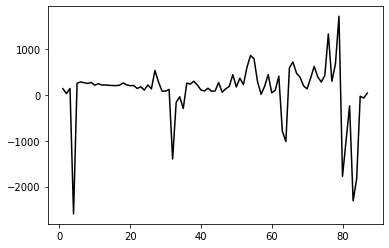

In [13]:
plt.plot(x, y, color="k")